[[27.23880543 23.83014303 14.3944554  ... 49.9020515  50.19250575
  49.98679394]]


Ce qui diffère en premier lieu entre une guitare et un Ukulele est la taille de l'instrument, et sa forme.
On peut décomposer la guitare et le Ukulele dans les mêmes décompositions élémentaires. 
Elles sont composées en 4 parties :
- La corde (non étudié ici)
- Le résonateur : qui comprend la cavité et le volume d'air
- La face avant du résonateur
- La face arrière du résonateur
Ce sont les éléments qui rentre en mouvement lors de l'excitation d'une corde.
On considère que la face arrière n'a qu'une influence minime puisque lorsque l'utilisateur joue de son Ukulele, il pose la face arrière sur son buste ce qui amortie les vibrations. Le luthier souhaite donc qu'il y aille le moins d'énergie transmise possible à l'arrière de l'instrument. On ne va pas l'étudier aujourd'hui.

La guitare utilisée ici est une guitare Yamaha C40 classique. Elle n'a pas de barrages lattice, c'est une guitare très répandue dans l'industrie de diapason 650mm. 
Le Ukulele est un Ukulele Tanglewood Soprano tiare, de diapason 345mm

Modèle bases fréquence

<img src="./strings.png">

Pour faire ce modèle, on ne va concidèrer qu'une partie de la décomposition élémentaire. Choses à mettre en lumière : pourquoi pas empècher la résonnance à l'arrière de l'instrument en fixant l'arrière de l'instrument une couverture.


Comme on mesure l'impédance juste à côté du point de jeu, cela permet de ne pas trop être embêté par les fréquences des modes de la partie arrière de l'instrument.
Le changement de volume est due au déplacement de la colonne d'air du résonnateur et du piston 
$$\Delta V = Ax_p + Bx_a$$ 

On applique un principe fondamental de la dynamique sur sur le piston puis sur le résonnateur.

$m_p \ddot{x_p} + k_p x_p + R_p \dot{x_p} - A \Delta P = F$

$m_a \ddot{x_a} + R_a \dot{x_a} - S \Delta P = 0$

delta p peut être exprimé en fonction de xa et xp
Ce sont donc deux équations couplées qui sont analytiquement résolvable.


Le modèle possède donc deux oscilateurs. Qui sont caractéristiques de la hauteur de la note obtenue, mais absolument pas du timbre.
F = pS. C'est la différence des forces de pression entre les deux plaques qui permet de déterminer.
On prend aussi en compte les forces résistives de l'air. Il s'agit de l'énergie dissipée par frottement visqueux. Ces frottements permettent de déterminer le temps de la note et sont des pertes par rayonnement de l'onde sonore. F = dpS.

On concidère qu'il n'y a pas de transfert de température, d'où delta p = - mu deltaV.




On trouve finalement le système d'équation :

$m_p \ddot{x_p} + (k_p + \mu A^2 ) x_p + R_p \dot{x_p} = F$

$m_a \ddot{x_a} - R_a \dot{x_a} - S \Delta P = 0$

En forme matricielle :

$$M \ddot{X} + R \dot{X} + K X = F$$



$ M = \begin{bmatrix} m_p & 0 \\ 0 & m_a \end{bmatrix}  $
$ R = \begin{bmatrix} R_p & 0 \\ 0 & R_a \end{bmatrix}  $
$ C = \begin{bmatrix} k_p + \mu A^2 & \mu S A \\ \mu S A & \mu S^2  \end{bmatrix}  $

On applique une transformée de Fourier
$$(-\omega^2 M  + j \omega R + K ) X = F$$
On appelle $ \mathbb{G} =  -\omega^2 M  + j \omega R + K $
d'où $$ \mathbb{G} X = F $$

On peut avant noter deux pulsations remarcables : $\omega_p = \left[\frac{k_p + \mu A^2}{m_p}\right]^{1/2}$ et $\omega_h = \left[\frac{\mu S^2}{m_a}\right]^{1/2}$ et le facteur de couplage $\alpha = \mu S A$.

Si $ det(\Omega) = 0 $, alors, on peut déterminer les fréquences de coupures. d'où en négligeant les frottements :
$$(\omega^2 -\omega_p^2)(\omega^2 -\omega_a^2) - \frac{\alpha^2}{m_p m_a} = 0$$
D'où avec le changement de variable $\Omega =\omega^2$, on obtient une equation de degré 2 dont les racines sont :
$$\omega_\pm ^ 2 = 1/2(\omega_p^2 + \omega_h^2) \pm 1/2 \left[ (\omega_p^2 - \omega_h^2)^2 +4 \frac{\alpha}{(m_p m_a)^{1/2}} \right]^{1/2}$$

We now have everything we need to apply this model to guitar and to ukulele

In [147]:
import numpy as np

c = 343.3 #m/s
rho = 1.205 #kg/m3
Poisson_coef = 0.2 # pour du bois

# valeurs pour un ukulele

#V_u = (0.345*520/752.2)*(0.345*330/752.2)*(0.345*90/752.2)
#S_u = np.pi*(0.345*104/(2*752.2))**2
#A_u = np.pi*(0.345*287/(752.2*2))**2
V_u = 0.238*0.151*0.041
S_u = np.pi*(0.024)**2
rho_tilleul = 417 #kg/m3
A_u = np.pi*0.066**2
mu_u = c**2*rho/V_u
e_u = 1.5E-3
m_p_u = S_u*e_u*rho_tilleul
m_a_u = A_u*e_u*rho
E_tilleul = 7000




# valeurs pour une guitare
#V_g = (0.650*2780/3732)*(0.650*1900/3732)*(0.650*432/3732)*4
#S_g = np.pi*(0.650*501/3838/2)**2
#A_g = np.pi* (0.650*1675/3838/2)**2
V_g = 0.484*0.331*0.075
S_g = np.pi*0.042**2
rho_epicea = 450 #kg/m3
# on prend pour la surface vibrante de la guitare un cercle de diametre environ égale à la partie inférieure de l'instrument
A_g = np.pi* 0.141**2
mu_g = c**2*rho/V_g
e_g = 2.7E-3
m_p_g = S_g*e_g*rho_epicea
m_a_g = A_g*e_g*rho
# stiffness of wood and young module https://amesweb.info/Materials/Youngs-Modulus-of-Wood.aspx https://en.wikipedia.org/wiki/Vibration_of_plates
E_epicea = 9000

# On regroupe pour éviter de se perdre avec les indices, l'indice 0 est la guitare, l'indice 1 est le ukulele 
A = np.array([A_g, A_u])
rho_bois = np.array([rho_epicea, rho_tilleul])
V = np.array([V_g, V_u])
S = np.array([S_g, S_u])
e = np.array([e_g, e_u])
m_p = np.array([m_p_g, m_p_u])
m_a = np.array([m_a_g, m_a_u])
mu = np.array([mu_g, mu_u])
E = np.array([E_epicea, E_tilleul])


def model_guitar(e,mu,A,S,m_a,m_p,E,Poisson_coef):
    k_p = 2*E*e**3/(3*(1-Poisson_coef**2))/S

    omega_p = ((k_p + mu*A**2)/m_p)**0.5
    omega_h = ((mu*S**2)/m_a)**0.5
    alpha = S*A*mu

    omega1 = (0.5*(omega_p**2+omega_h**2)-0.5*((omega_p**2-omega_h**2)**2+4*alpha/(m_p*m_a)**0.5)**0.5)**0.5

    omega2 = (0.5*(omega_p**2+omega_h**2)+0.5*((omega_p**2-omega_h**2)**2+4*alpha/(m_p*m_a)**0.5)**0.5)**0.5

    return omega1, omega2

omega1,omega2 = model_guitar(e,mu,A,S,m_a,m_p,E,Poisson_coef)
print("guitar first frequencies : ", omega1[0]/(2*np.pi), ' and ', omega2[0]/(2*np.pi))
print("ukulele first frequencies : ", omega1[1]/(2*np.pi), ' and ', omega2[1]/(2*np.pi))

guitar first frequencies :  212.7154643220687  and  416.4817809277114
ukulele first frequencies :  568.5030945963558  and  635.5601468338263


In [ ]:
import scipy.io
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('./guitar/A vide 3.fig.mat')
frequencies = mat["frequency"][0][0:3300]
accelerance = mat["accelerance"][0][0:3300]

plt.plot(frequencies,accelerance)

On obtient des fréquences qui ne sont pas concordante avec la réalité. Cela peut être du à la mesure approximative des mesures de l'instrument, au modèle trop simpliste, la géométrie de la guitare.
Dans la suite, on prendra des valeurs de volume et de surface qui permettent d'obtenir des fréquences qui correspondent à celles trouvées expérimentalement.
L'objectif maintenant est de suivre le comportement des fréquences et voir si le même comportement est vu pour les cordes ou les percussions.

In [144]:

c = 343.3 #m/s
rho = 1.205 #kg/m3
Poisson_coef = 0.2 # pour du bois

# valeurs pour un ukulele

#V_u = (0.345*520/752.2)*(0.345*330/752.2)*(0.345*90/752.2)
#S_u = np.pi*(0.345*104/(2*752.2))**2
#A_u = np.pi*(0.345*287/(752.2*2))**2
V_u = 0.238*0.151*0.041
S_u = np.pi*(0.024)**2
rho_tilleul = 417 #kg/m3
A_u = np.pi*0.066**2
mu_u = c**2*rho/V_u
e_u = 1.5E-3
m_p_u = S_u*e_u*rho_tilleul
m_a_u = A_u*e_u*rho
E_tilleul = 7000




# valeurs pour une guitare
#V_g = (0.650*2780/3732)*(0.650*1900/3732)*(0.650*432/3732)*4
#S_g = np.pi*(0.650*501/3838/2)**2
#A_g = np.pi* (0.650*1675/3838/2)**2
V_g = 0.484*0.331*0.075*4.3
S_g = np.pi*0.042**2
rho_epicea = 450 #kg/m3
# on prend pour la surface vibrante de la guitare un cercle de diametre environ égale à la partie inférieure de l'instrument
A_g = np.pi* 0.141**2
mu_g = c**2*rho/V_g
e_g = 2.7E-3
m_p_g = S_g*e_g*rho_epicea
m_a_g = A_g*e_g*rho
# stiffness of wood and young module https://amesweb.info/Materials/Youngs-Modulus-of-Wood.aspx https://en.wikipedia.org/wiki/Vibration_of_plates
E_epicea = 9000

# On regroupe pour éviter de se perdre avec les indices, l'indice 0 est la guitare, l'indice 1 est le ukulele 
A = np.array([A_g, A_u])
rho_bois = np.array([rho_epicea, rho_tilleul])
V = np.array([V_g, V_u])
S = np.array([S_g, S_u])
e = np.array([e_g, e_u])
m_p = np.array([m_p_g, m_p_u])
m_a = np.array([m_a_g, m_a_u])
mu = np.array([mu_g, mu_u])
E = np.array([E_epicea, E_tilleul])


# On regroupe pour éviter de se perdre avec les indices, l'indice 0 est la guitare, l'indice 1 est le ukulele 
A = np.array([A_g, A_u])
rho_bois = np.array([rho_epicea, rho_tilleul])
V = np.array([V_g, V_u])
S = np.array([S_g, S_u])
e = np.array([e_g, e_u])
m_p = np.array([m_p_g, m_p_u])
m_a = np.array([m_a_g, m_a_u])
mu = np.array([mu_g, mu_u])
E = np.array([E_epicea, E_tilleul])

omega1,omega2 = model_guitar(e,mu,A,S,m_a,m_p,E,Poisson_coef)
print("guitar first frequencies : ", omega1[0]/(2*np.pi), ' and ', omega2[0]/(2*np.pi))
print("ukulele first frequencies : ", omega1[1]/(2*np.pi), ' and ', omega2[1]/(2*np.pi))

guitar first frequencies :  102.58044036047811  and  200.8455424054778
ukulele first frequencies :  568.5030945963558  and  635.5601468338263


Le modèle est trop simpliste et ne permet malheuresement pas d'obtenir des valeurs réelles.
C'est pour cela que dans le papier, les valeurs f1, f2 sont définies comme connues avant l'expérience, et les valeurs des pulsations omega_p et omega_h sont déterminées à partir de ces fréquences et non de la géométrie de la guitare.

Pour obtenir des valeurs cohérentes, on ajuste les termes de la guitare

0.0038345814000000002
0.012015300000000001


Qu'obtient-on expérimentalement ?

à vide

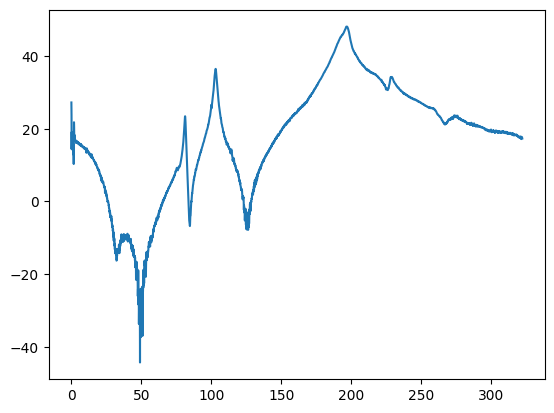

In [127]:
import scipy.io
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('./guitar/A vide 3.fig.mat')
frequencies = mat["frequency"][0][0:3300]
accelerance = mat["accelerance"][0][0:3300]

plt.plot(frequencies,accelerance)

  après recherche des racines du polynome $ det(\Omega - \lambda I_2) $ pour déterminer les pulsations de coupures et on obtient une équation de degré deux en \lambda, dont les racines sont trop complexe à déterminer analitiquement : 


In [1]:
0.650*501/3732

0.08725884244372992